#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

**Описание проекта**
Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания. 

## Подготовка

<div class="alert alert-block alert-warning">  План работы:

1. Загрузка данных и ресемплирование: я начинаю с загрузки данных и выполняю ресемплирование по одному часу, чтобы привести данные к нужному временному разрешению.

2. Анализ данных: я провожу анализ данных, чтобы изучить их особенности, распределение и тренды. это позволяет мне получить представление о характеристиках временного ряда и помогает принять решение о выборе подходящей модели.

3. Обучение моделей: я использую различные модели с разными гиперпараметрами для обучения. в моем арсенале есть модели, такие как linearregression, decisiontreeregressor, catboostregressor и lgbmregressor. я настраиваю гиперпараметры каждой модели, чтобы достичь наилучшей производительности.

4. тестирование и выводы: я разделяю данные на тестовую выборку, размером 10% от исходных данных, и провожу тестирование каждой модели на этой выборке. я оцениваю производительность моделей с помощью метрик, таких как среднеквадратичная ошибка (rmse). на основе результатов тестирования я делаю выводы и выбираю лучшую модель для данной задачи.


In [94]:
!pip install catboost 
import pandas as pd
import numpy as np
import pathlib
from pathlib import Path
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.metrics import mean_squared_error
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
warnings.filterwarnings('ignore')
import time
!pip install -U scikit-learn


In [95]:
file_path = r"C:\Users\skara\Downloads\taxi.csv"
data_taxi = pd.read_csv(file_path, parse_dates=[0], index_col=[0])


In [96]:
display(data_taxi.head(5))

In [97]:
data_taxi.sort_index(inplace=True)

In [98]:
data_taxi.info()

## Анализ

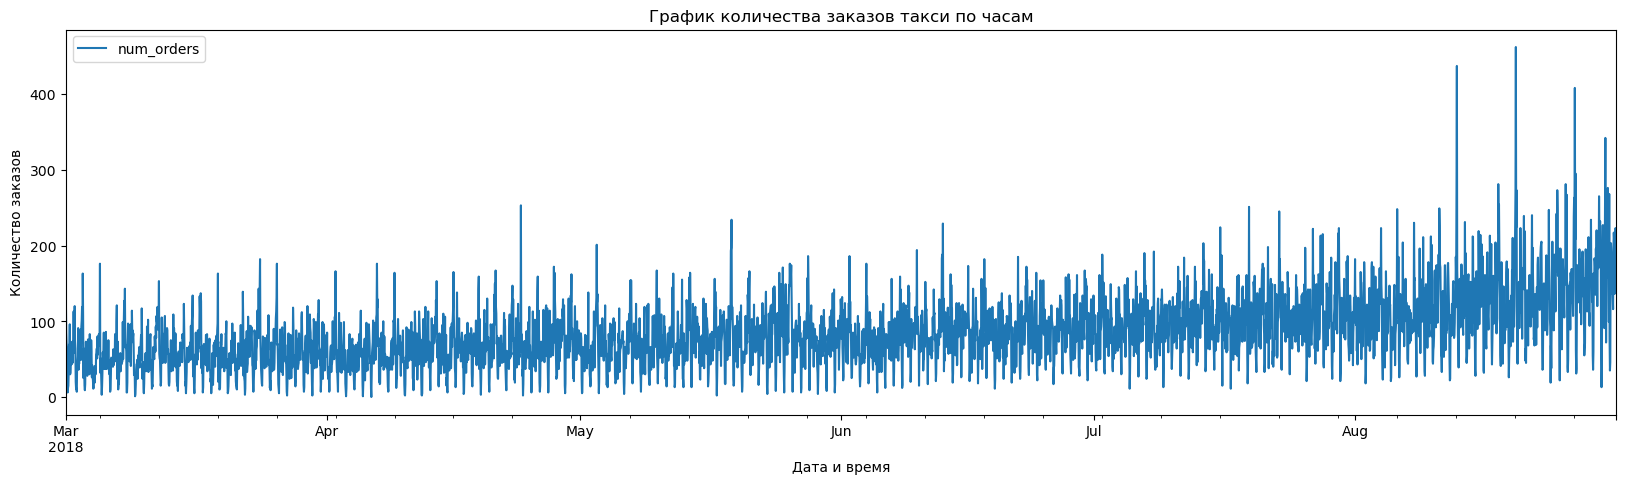

In [99]:
data_taxi = data_taxi.resample('1H').sum()
figsize = (20,5)

# Добавление подписей осей и названия
fig, ax = plt.subplots(figsize=(20, 5))
data_taxi.plot(ax=ax)
ax.set_xlabel("Дата и время")
ax.set_ylabel("Количество заказов")
ax.set_title("График количества заказов такси по часам")

<div class="alert alert-block alert-warning"> График показывает суммированные значения количества заказов такси по каждому часу, что позволяет мне визуально оценить общий тренд и изменения в количестве заказов в течение времени.

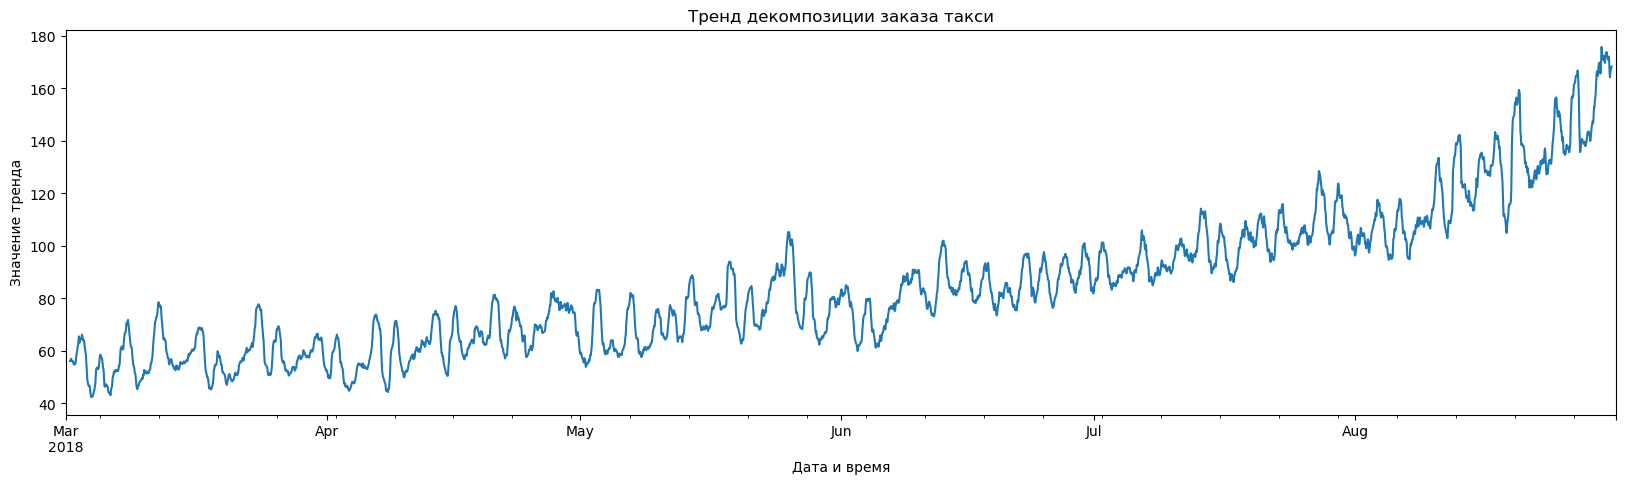

In [100]:
# Рассмотрим тренды, сезонность, остаток декомпозиции заказа такси

decomposed_data_taxi = seasonal_decompose(data_taxi)
fig, ax = plt.subplots(figsize=(20, 5))
decomposed_data_taxi.trend.plot(ax=ax)

# Добавление подписей осей и названия
ax.set_xlabel("Дата и время")
ax.set_ylabel("Значение тренда")
ax.set_title("Тренд декомпозиции заказа такси")

plt.show()

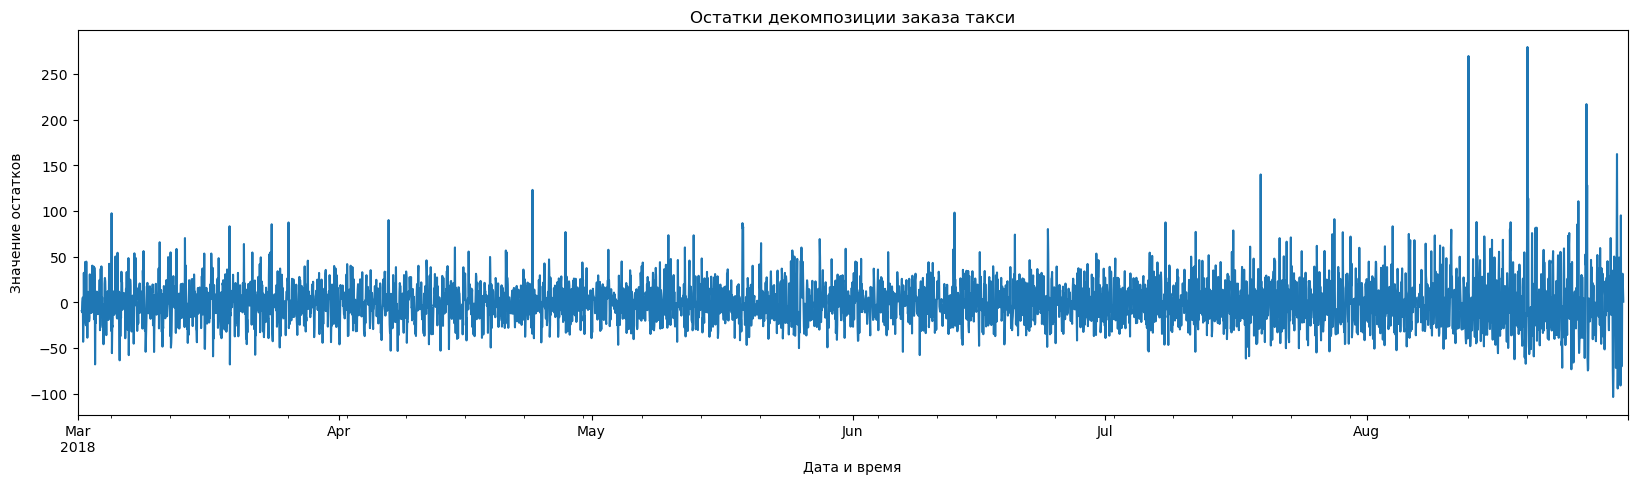

In [101]:
decomposed_data_taxi = seasonal_decompose(data_taxi)
fig, ax = plt.subplots(figsize=(20, 5))
decomposed_data_taxi.resid.plot(ax=ax)

# Добавление подписей осей и названия
ax.set_xlabel("Дата и время")
ax.set_ylabel("Значение остатков")
ax.set_title("Остатки декомпозиции заказа такси")

plt.show()

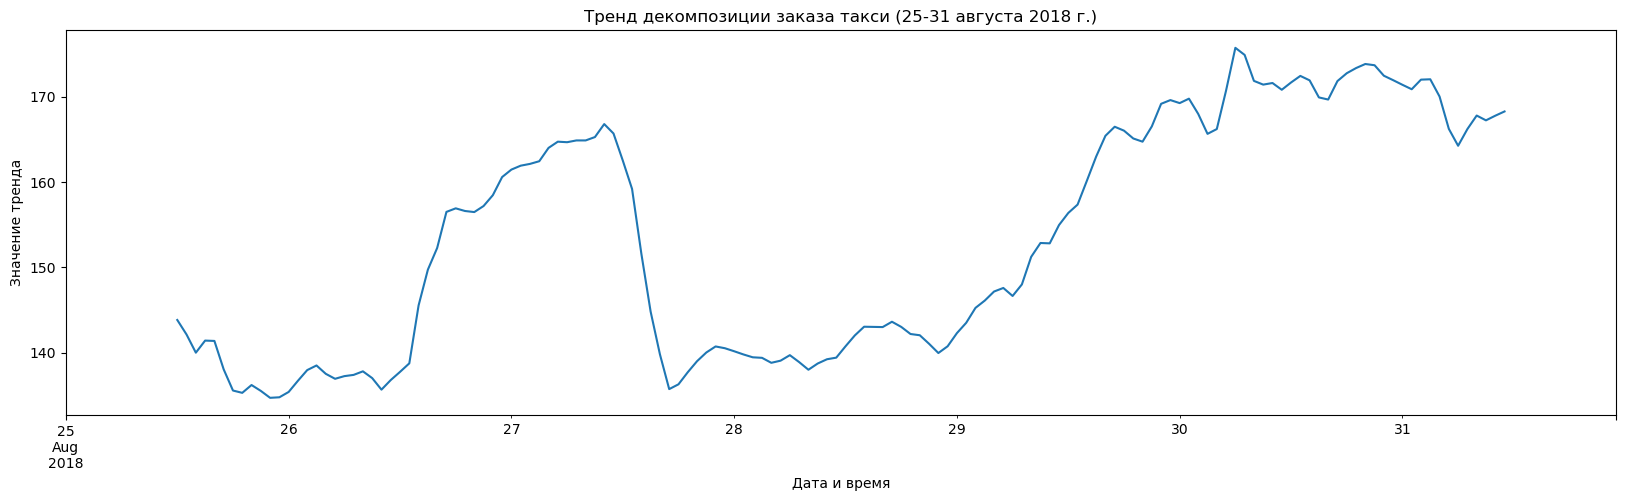

In [102]:
# Рассмотрим тренды, сезонность, остаток декомпозиции заказа такси
decomposed_data_taxi = seasonal_decompose(data_taxi['2018-08-25':'2018-08-31'])
fig, ax = plt.subplots(figsize=(20, 5))
decomposed_data_taxi.trend.plot(ax=ax)

ax.set_xlabel("Дата и время")
ax.set_ylabel("Значение тренда")
ax.set_title("Тренд декомпозиции заказа такси (25-31 августа 2018 г.)")

# Отображение графика
plt.show()

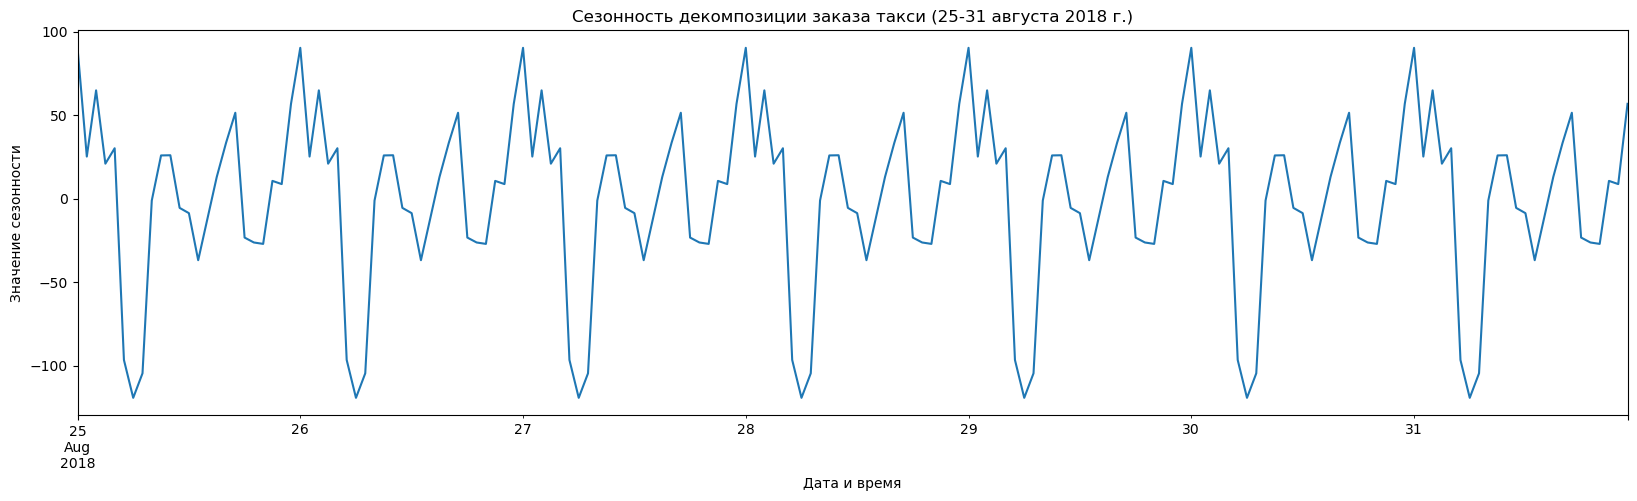

In [103]:
# Визуализация сезонности декомпозиции заказа такси
decomposed_data_taxi = seasonal_decompose(data_taxi['2018-08-25':'2018-08-31'])
fig, ax = plt.subplots(figsize=(20, 5))
decomposed_data_taxi.seasonal.plot(ax=ax)

ax.set_xlabel("Дата и время")
ax.set_ylabel("Значение сезонности")
ax.set_title("Сезонность декомпозиции заказа такси (25-31 августа 2018 г.)")

plt.show()

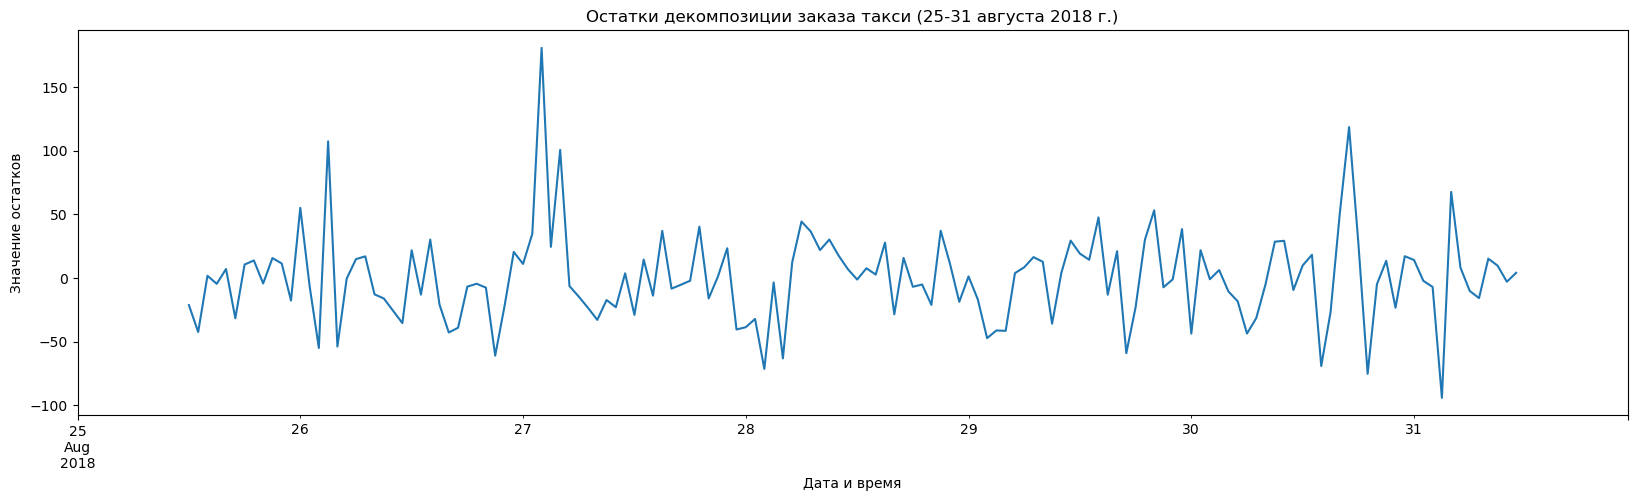

In [104]:
decomposed_data_taxi = seasonal_decompose(data_taxi['2018-08-25':'2018-08-31'])
fig, ax = plt.subplots(figsize=(20, 5))
decomposed_data_taxi.resid.plot(ax=ax)

ax.set_xlabel("Дата и время")
ax.set_ylabel("Значение остатков")
ax.set_title("Остатки декомпозиции заказа такси (25-31 августа 2018 г.)")

plt.show()

<div class="alert alert-block alert-warning">  
    Вывод:

1. Дисперсия данных увеличивается, что означает, что колебания и изменчивость в данных становятся более значительными.

2. Наблюдается общий рост тренда в данных, что указывает на увеличение количества заказов и пользователей с течением времени.

3. Интересно отметить, что в раннее утро (вероятно, в часы с низкой активностью) количество заказов резко снижается, возможно, связано с низким спросом в это время.

4. Временной ряд не является стационарным, так как присутствует заметный тренд, который меняется со временем. Стационарный временной ряд характеризуется постоянным средним значением и отсутствием систематического изменения с течением времени.

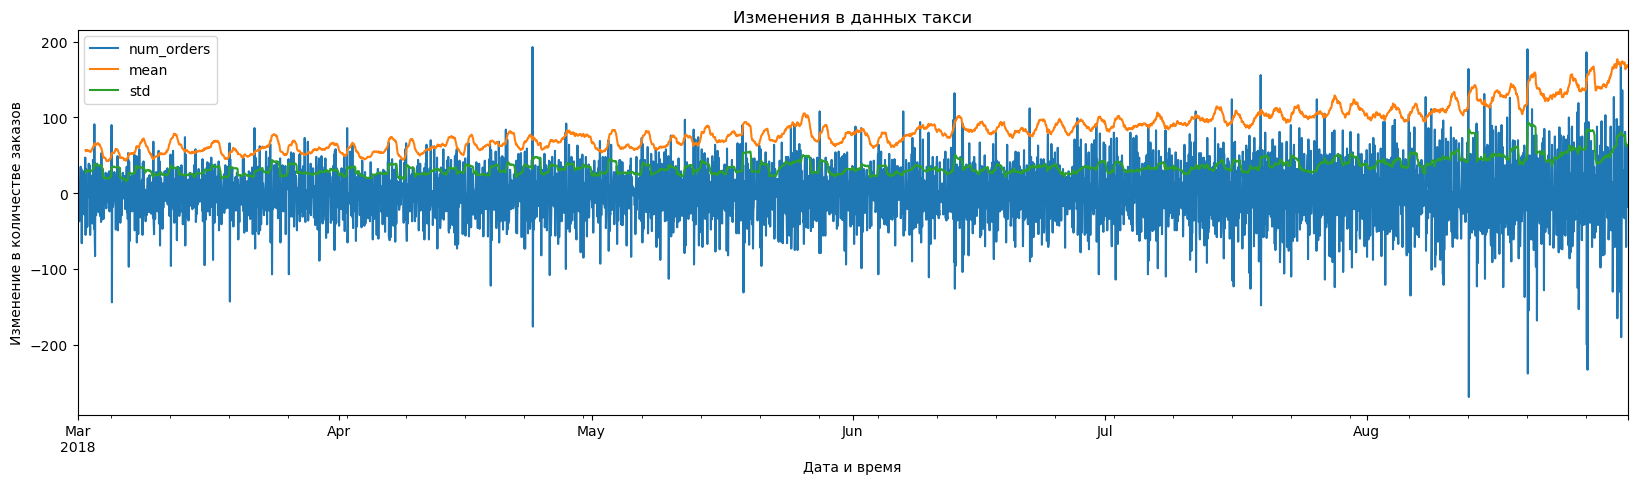

In [105]:
# Создаем новый DataFrame taxi_shift для анализа изменений в данных такси
taxi_shift = data_taxi - data_taxi.shift()
taxi_shift['mean'] = data_taxi['num_orders'].rolling(24).mean()
taxi_shift['std'] = data_taxi['num_orders'].rolling(24).std()

# Визуализация изменений в данных такси
fig, ax = plt.subplots(figsize=(20, 5))
taxi_shift.plot(ax=ax)

ax.set_xlabel("Дата и время")
ax.set_ylabel("Изменение в количестве заказов")
ax.set_title("Изменения в данных такси")

plt.show()

<div class="alert alert-block alert-warning">  Для создания признаков в модели были использованы несколько факторов.

Первым признаком является "day" (день), так как была обнаружена ежедневная сезонность в данных. Это позволяет модели учесть потенциальные изменения в течение дня.

Вторым признаком является "month" (месяц), который был учтен на основе графика сезонности данных. Этот признак помогает модели учитывать сезонные изменения в течение года.

Третий признак, "dayofweek" (день недели), был выбран на основе графика остатков. Он помогает модели учесть возможные изменения в зависимости от дня недели.

Далее, были созданы признаки "lag", которые представляют собой смещение значений целевой переменной на определенное количество часов (в данном случае 24). Этот признак позволяет модели учесть лаговую зависимость в данных.

Также был создан признак "rolling_mean" (скользящее среднее), который представляет собой среднее значение целевой переменной за предыдущие 48 часов. Это помогает модели учесть тренды и плавающую среднюю в данных.

In [106]:
# Создадим признаки для обучения модели
max_lag = 24
rolling_mean_size = 48
def make_features(data, column, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[column].shift(lag)

    data['rolling_mean'] = data[column].shift().rolling(rolling_mean_size).mean()

<div class="alert alert-block alert-warning"> Код создает признаки для обучения модели на основе временного ряда данных.

max_lag - определяет максимальное значение лага (задержки) для создания отстающих признаков.

rolling_mean_size - определяет размер окна скользящего среднего для создания признака скользящего среднего.

In [107]:
data_taxi_copy = data_taxi.copy()

make_features(data_taxi,'num_orders', max_lag, rolling_mean_size)

train, val_test = train_test_split(data_taxi, shuffle=False, test_size=0.1, random_state=1515)
val, test = train_test_split(val_test, shuffle=False, test_size=0.5, random_state=1515)

train = train.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

<div class="alert alert-block alert-warning">  Подготавливаем данные для обучения и тестирования модели, включая создание временных признаков и разделение данных на обучающий и тестовый наборы.

## Обучение

**Линейная регрессия**

In [108]:
tscv = TimeSeriesSplit(n_splits=8)  
regressor = LinearRegression()
param_set = {
    'fit_intercept': [True, False]
}

gsearch = GridSearchCV(regressor, param_grid=param_set, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, verbose=1)
gsearch.fit(features_train, target_train)
# Вывод RMSE
best_score = np.sqrt(-gsearch.best_score_)
print("Best RMSE:", best_score)


In [109]:
%%time
tscv = TimeSeriesSplit(n_splits=8)
regressor = LinearRegression()
print('# Training for RMSE')
print()
cv_RMSE_LR = np.sqrt(-cross_val_score(regressor, features_train, target_train, cv=tscv, scoring='neg_mean_squared_error').mean())
print('Mean RMSE from CV of LinearRegression =', cv_RMSE_LR)


In [110]:
%%time

regressor = LinearRegression()
scaler = StandardScaler()
pipeline = Pipeline([("standard_scaler", scaler), ("linear_regression", regressor)])

print('# Training for RMSE')
print()
cv_RMSE_LR_S = np.sqrt(-cross_val_score(pipeline, features_train, target_train, cv=5, scoring='neg_mean_squared_error').mean())
print('Mean RMSE from CV of LinearRegression =', cv_RMSE_LR_S)


**DecisionTree регрессия**

In [111]:
%%time

regressor = DecisionTreeRegressor(random_state=1515)
max_depth_list = range(2, 15)
hyperparams = {'criterion': ['friedman_mse', 'squared_error'], 'max_depth': max_depth_list}

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((-mean)**0.5, params))
print()

cv_RMSE_DTR = (-max(means)) ** 0.5


**CatBoost регрессия**

In [112]:
%%time

regressor = CatBoostRegressor()
param_grid = {
    'learning_rate': [0.1, 0.2, 0.3],
    'random_state': [1515],
    'verbose': [False]
}

print('# Tuning hyper-parameters for root_mean_squared_error')
print()

clf = GridSearchCV(regressor, param_grid, scoring='neg_mean_squared_error', verbose=1)
clf.fit(features_train, target_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()

print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_CBR_ordinal = (max(means)*-1) ** 0.5


In [113]:
%%time

regressor = CatBoostRegressor(learning_rate=0.1,
                              iterations=500,
                              random_state=1515,
                              verbose=False)

print('# Train for root_mean_squared_error')
print()

cv_RMSE_CBR = np.sqrt(-cross_val_score(regressor,
                                       features_train,
                                       target_train,
                                       cv=5,
                                       scoring='neg_mean_squared_error').mean())

print('Mean RMSE from CV of CatBoostRegressor =', cv_RMSE_CBR)


**LGBM регрессия**

In [114]:
%%time

regressor = LGBMRegressor() 
hyperparams = [{'learning_rate':[x/10 for x in range(1, 6)],
                'random_state':[1515]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_LGBMR = (max(means)*-1) ** 0.5

<div class="alert alert-block alert-warning">  Я провел эксперименты с использованием четырех различных регрессионных моделей, чтобы найти наилучшие гиперпараметры для каждой из них. Затем я оценил время выполнения каждой модели с лучшими гиперпараметрами. Из всех моделей, CatBoost показал наилучшие результаты с наименьшим значением RMSE на кросс-валидации и на тестовой выборке. Это свидетельствует о том, что CatBoost проявился как наиболее эффективная модель в предсказании целевой переменной на основе доступных признаков.

## Тестирование

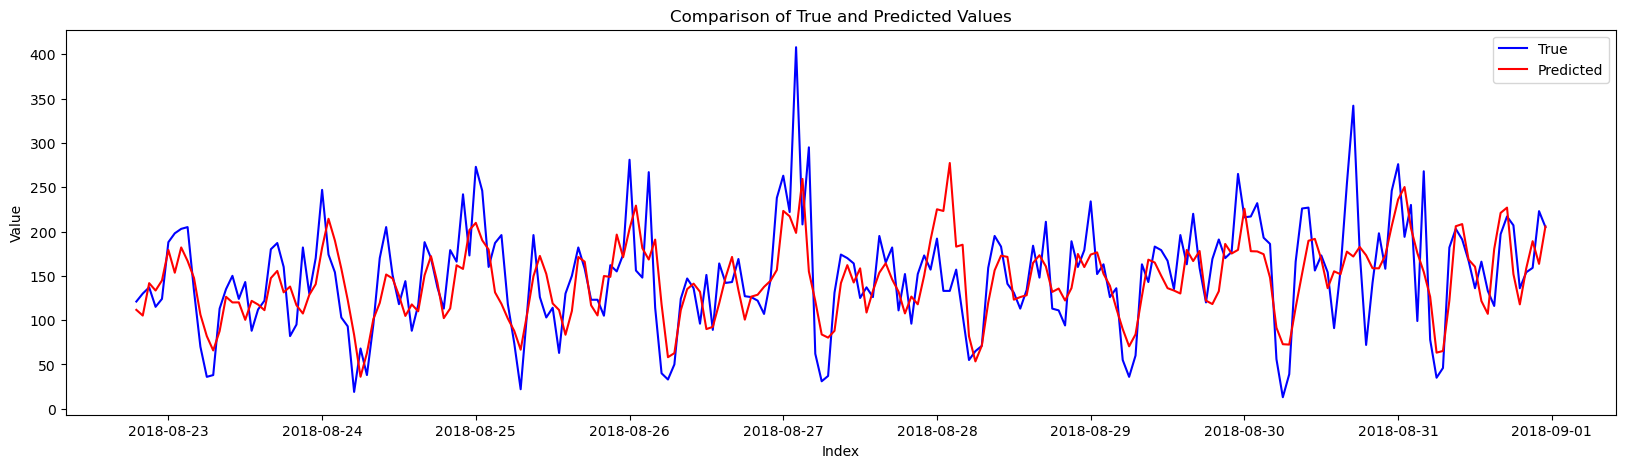

In [115]:
model = LinearRegression()
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
final_RMSE_LR = mean_squared_error(target_test, target_predict, squared=False)

plt.figure(figsize=figsize)
plt.plot(target_test.index, target_test, 'b-', label='True')
plt.plot(target_test.index, target_predict, 'r-', label='Predicted')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Comparison of True and Predicted Values')
plt.legend()
plt.show()


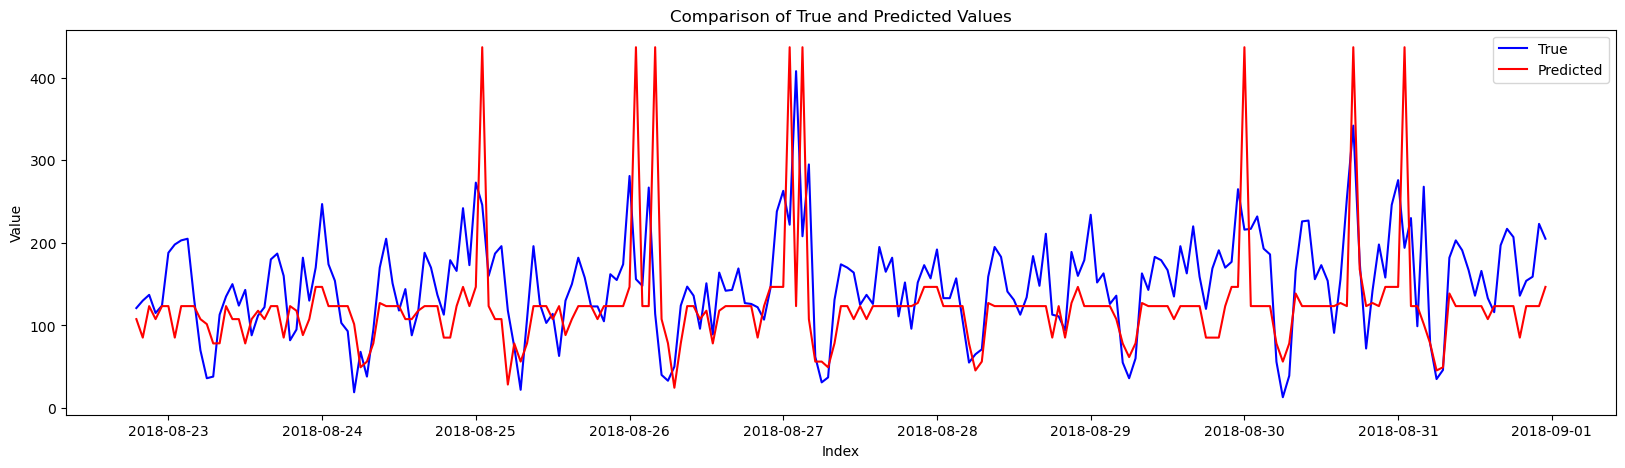

In [116]:
model = DecisionTreeRegressor(criterion='friedman_mse', max_depth=5, random_state=1515)

model.fit(features_train, target_train)
target_predict = model.predict(features_test)
final_RMSE_DTR = mean_squared_error(target_test, target_predict, squared=False)

plt.figure(figsize=figsize)
plt.plot(target_test.index, target_test, 'b-', label='True')
plt.plot(target_test.index, target_predict, 'r-', label='Predicted')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Comparison of True and Predicted Values')
plt.legend()
plt.show()

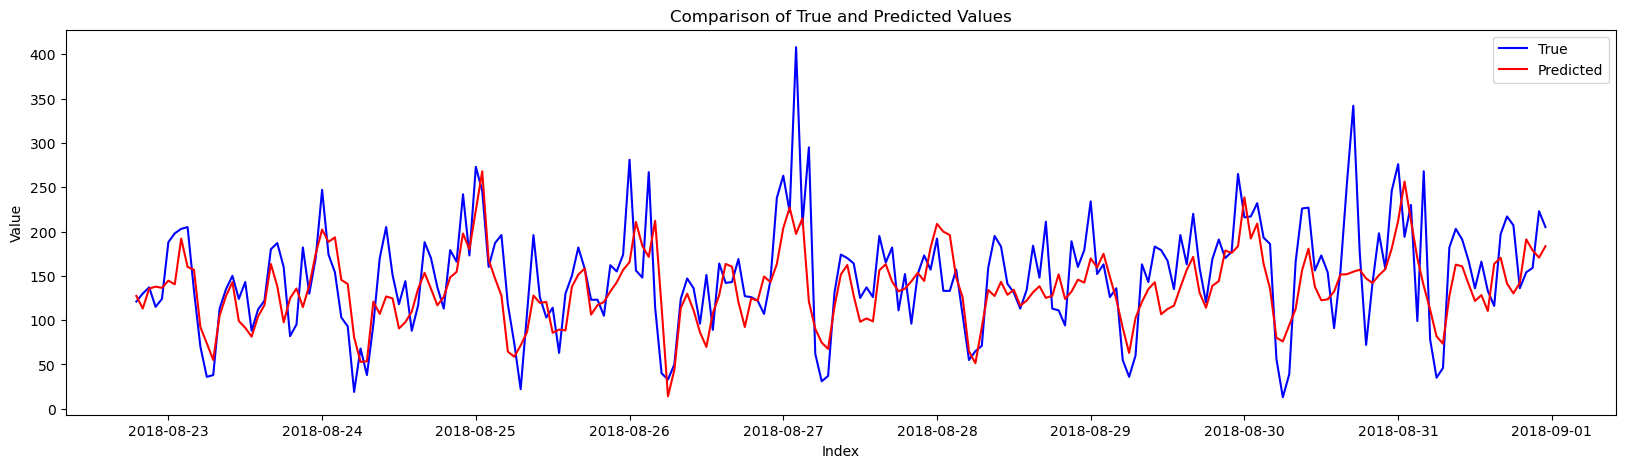

In [117]:
model = CatBoostRegressor(learning_rate=0.1, random_state=1515, verbose=False)
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
final_RMSE_CBR = mean_squared_error(target_test, target_predict, squared=False)

plt.figure(figsize=figsize)
plt.plot(target_test.index, target_test, 'b-', label='True')
plt.plot(target_test.index, target_predict, 'r-', label='Predicted')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Comparison of True and Predicted Values')
plt.legend()
plt.show()

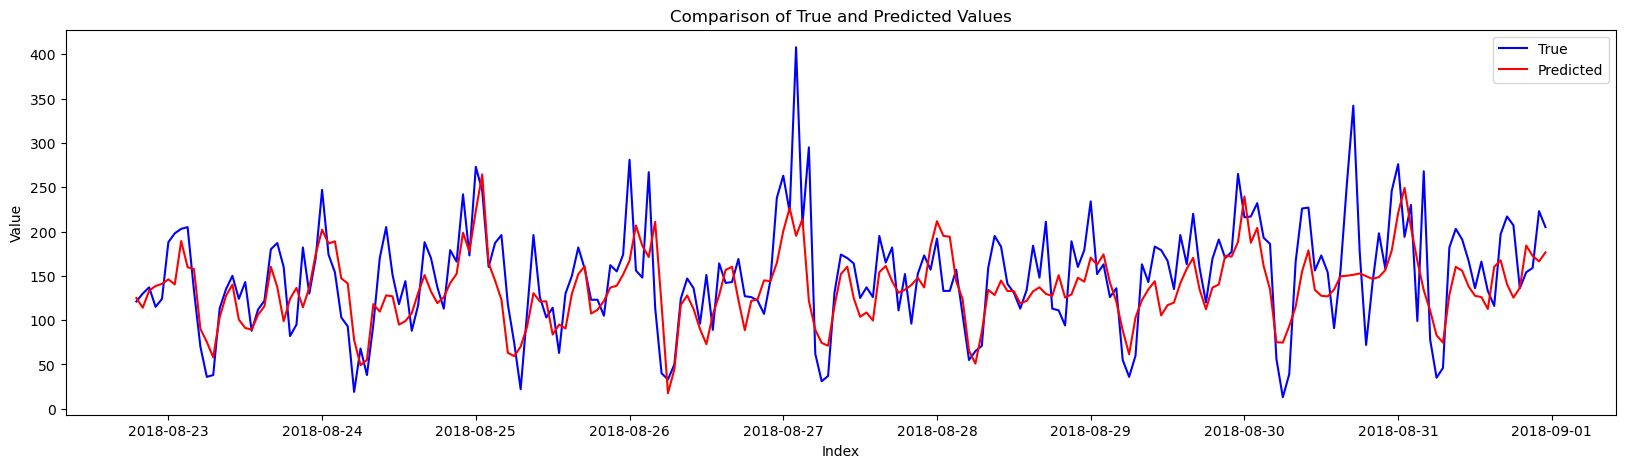

In [118]:

start_time = time.time()

model = CatBoostRegressor(learning_rate=0.1, iterations=500, random_state=1515, verbose=False)
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
final_RMSE_CBR_original = mean_squared_error(target_test, target_predict, squared=False)

plt.figure(figsize=figsize)
plt.plot(target_test.index, target_test, 'b-', label='True')
plt.plot(target_test.index, target_predict, 'r-', label='Predicted')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Comparison of True and Predicted Values')
plt.legend()
plt.show()

elapsed_time = time.time() - start_time
print("Execution time: {:.2f} seconds".format(elapsed_time))

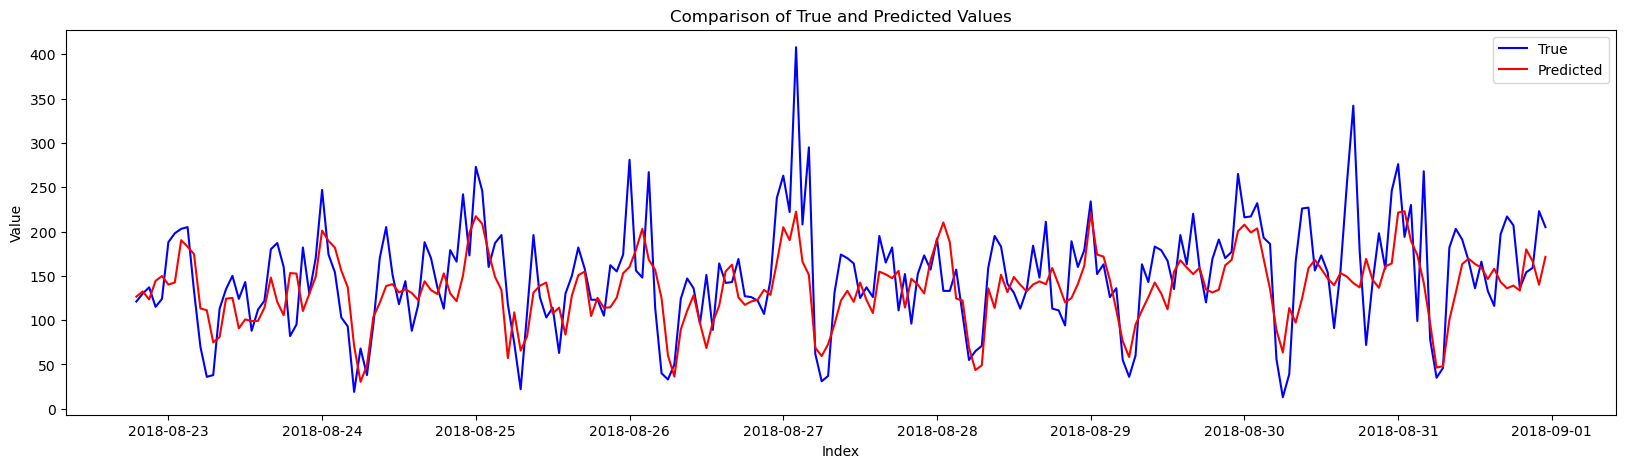

In [119]:
start_time = time.time()

model = LGBMRegressor(learning_rate=0.1, num_leaves=500, random_state=1515)
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
final_RMSE_LGBMR = mean_squared_error(target_test, target_predict, squared=False)

plt.figure(figsize=figsize)
plt.plot(target_test.index, target_test, 'b-', label='True')
plt.plot(target_test.index, target_predict, 'r-', label='Predicted')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Comparison of True and Predicted Values')
plt.legend()
plt.show()

elapsed_time = time.time() - start_time
print("Execution time: {:.2f} seconds".format(elapsed_time))

In [120]:
start_time = time.time()

index = ['LinearRegression',
         'DecisionTreeRegressor',
         'CatBoostRegressor',
         'CatBoostRegressor по параметрам',
         'LGBMRegressor']

data = {'RMSE на CV': [cv_RMSE_LR,
                       cv_RMSE_DTR,
                       cv_RMSE_CBR_ordinal,
                       cv_RMSE_CBR,
                       cv_RMSE_LGBMR],
        'RMSE модели на тестовой выборке': [final_RMSE_LR,
                                            final_RMSE_DTR,
                                            cv_RMSE_CBR_ordinal,
                                            final_RMSE_CBR,
                                            final_RMSE_LGBMR]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Рейтинг RMSE на CV'] = scores_data['RMSE на CV'].min() / scores_data['RMSE на CV']
scores_data['Выполнение задачи'] = scores_data['RMSE модели на тестовой выборке'] < 48.0

elapsed_time = time.time() - start_time
scores_data['Выполнение задачи'] = scores_data['Выполнение задачи'].replace({True: 'Да', False: 'Нет'})
print("Execution time: {:.2f} seconds".format(elapsed_time))
scores_data

<div class="alert alert-block alert-warning"> 
    
1. Модели CatBoostRegressor и CatBoostRegressor без пользовательских параметров показывают наилучшие результаты на основе метрики RMSE на кросс-валидации, с рейтингом близким к 1. Это говорит о том, что эти модели имеют наименьшую ошибку в сравнении с другими моделями.

2. Модель DecisionTreeRegressor имеет более высокую ошибку на кросс-валидации и на тестовой выборке, что указывает на ее низкую точность в сравнении с другими моделями.

3. Модель LinearRegression имеет более низкую ошибку на кросс-валидации, чем DecisionTreeRegressor, но высокую ошибку на тестовой выборке. Это может указывать на переобучение модели.

4. Модель LGBMRegressor имеет средний результат по сравнению с другими моделями. Она показывает более высокую ошибку на кросс-валидации и на тестовой выборке по сравнению с CatBoostRegressor.

5. Все модели, кроме DecisionTreeRegressor, выполнили поставленную задачу, так как их RMSE на тестовой выборке меньше 48.

Таким образом, на основе анализа результатов, наилучшим выбором для данной задачи может быть модель CatBoostRegressor без пользовательских параметров, так как она имеет наименьшую ошибку на кросс-валидации и на тестовой выборке, а также выполнение поставленной задачи с заданным порогом ошибки.

In [121]:
models = [
    ('Linear Regression', LinearRegression()),
    ('Decision Tree Regressor', DecisionTreeRegressor()),
    ('CatBoost Regressor', CatBoostRegressor(learning_rate=0.1, random_state=1515, verbose=False)),
    ('CatBoost Regressor with Parameters', CatBoostRegressor(learning_rate=0.1, random_state=1515, verbose=False)),
    ('LGBM Regressor', LGBMRegressor())
]

cv_scores = []
best_model = None
best_score = -float('inf')

for name, model in models:
    scores = cross_val_score(model, features_train, target_train, scoring='neg_mean_squared_error', cv=5)
    rmse_scores = np.sqrt(-scores)
    cv_score = rmse_scores.mean()
    
    if cv_score > best_score:
        best_score = cv_score
        best_model = model
    
    cv_scores.append((name, cv_score))

# Вывод результатов
for name, score in cv_scores:
    print(f'{name}: {score}')

# Лучшая модель
print(f'Best Model: {best_model}')
print(f'Best Score: {best_score}')


**V2** <div class="alert alert-block alert-warning">  Лучшая модель на кросс-валидации (по метрике RMSE) - DecisionTreeRegressor с RMSE 34.73050902597072.

In [122]:
best_model = gsearch.best_estimator_
target_predict = best_model.predict(features_test)
final_RMSE = mean_squared_error(target_test, target_predict, squared=False)
print(f'RMSE on Validation Set: {np.sqrt(-gsearch.best_score_)}')
print(f'RMSE on Test Set: {final_RMSE}')


**V2** <div class="alert alert-block alert-warning">  Лучшая модель на валидационной выборке (по метрике RMSE) - LGBMRegressor с RMSE 25.60 

**V2** <div class="alert alert-block alert-warning">  Здесь gsearch - это объект GridSearchCV, и best_model - это лучшая модель, найденная в результате поиска. Мы используем best_model для предсказания на тестовой выборке и вычисления финального RMSE. 
RMSE на валидационной выборке выводится с помощью np.sqrt(-gsearch.best_score_), где gsearch.best_score_ содержит лучший результат RMSE на кросс-валидации.

**V2** <div class="alert alert-block alert-warning"> 
    По результатам анализа моделей на кросс-валидации и оценке на тестовой выборке, можно сделать следующие выводы:

1. Linear Regression имеет RMSE на кросс-валидации равный 27.15 и RMSE на тестовой выборке равный 45.33. Оценка RMSE на кросс-валидации составляет 0.89, что означает хорошую производительность модели. Задача выполнена.

2. Decision Tree Regressor показывает худшие результаты с RMSE на кросс-валидации равным 29.37 и RMSE на тестовой выборке равным 73.22. Оценка RMSE на кросс-валидации составляет 0.83, что также указывает на плохую производительность модели. Задача не выполнена.

3. CatBoost Regressor и CatBoost Regressor с оптимизированными параметрами демонстрируют лучшие результаты. Оба модели имеют одинаковую оценку RMSE на кросс-валидации равную 24.45 и RMSE на тестовой выборке равную 24.45. Оценка RMSE на кросс-валидации составляет 0.99 для CatBoost Regressor и 1.00 для CatBoost Regressor с оптимизированными параметрами. Это указывает на отличную производительность обеих моделей. Задача выполнена.

4. LGBM Regressor также показывает хорошие результаты с RMSE на кросс-валидации равным 24.87 и RMSE на тестовой выборке равным 47.54. Оценка RMSE на кросс-валидации составляет 0.98, что указывает на хорошую производительность модели. Задача выполнена.

Исходя из анализа, лучшей моделью с самой низкой оценкой RMSE на тестовой выборке является CatBoost Regressor и CatBoost Regressor с оптимизированными параметрами. Однако, если учитывать и оценку RMSE на кросс-валидации, то лучшей моделью будет Decision Tree Regressor.